# Sensitivity Analysis

The following tutorial demonstrates how one may perform a sensitivity analysis of a simulation model via `calisim`. We will first import our required dependencies.

In [99]:
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.example_models import SirOdesModel
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

## SIR Model Parameters and Initial Conditions

We next define our forward model. We will use an SIR (susceptible, infected, and recovered) compartmental model, combined with SciPy's solver for ordinary differential equations. The SIR model is expressed as a system of ordinary differential equations where:

| Parameter | Value | Description |
|-----------|-------|-------------|
| β (beta)  | 0.4   | Infection rate: probability of transmission per contact per time unit |
| γ (gamma) | 0.1   | Recovery rate: fraction of infected recovering per time unit |
|           |       | **Average infectious period = 1 / γ = 10 time units** |

With the following compartments:

| Compartment | Symbol | Initial Value | Description |
|------------|--------|---------------|-------------|
| Susceptible | S0     | 999           | Individuals who can catch the disease (N - I0 - R0) |
| Infected    | I0     | 1.0           | Individuals currently infected and can spread the disease |
| Recovered   | R0     | 0             | Individuals recovered or removed; no longer infectious |

In [100]:
def sir_simulate(parameters: dict) -> np.ndarray | pd.DataFrame:
    def dX_dt(_: np.ndarray, X: np.ndarray) -> np.ndarray:
        S, I, _ = X
        dotS = -parameters["beta"] * S * I / parameters["N"]
        dotI = (
            parameters["beta"] * S * I / parameters["N"] - parameters["gamma"] * I
        )
        dotR = parameters["gamma"] * I
        return np.array([dotS, dotI, dotR])

    X0 = [parameters["S0"], parameters["I0"], parameters["R0"]]
    t = (parameters["t"].min(), parameters["t"].max())
    x_y = solve_ivp(
        fun=dX_dt, y0=X0, t_span=t, t_eval=parameters["t"].values.flatten()
    ).y

    df = pd.DataFrame(dict(dotS=x_y[0, :], dotI=x_y[1, :], dotR=x_y[2, :]))
    return df

We will perform a simulation study with the following ground-truth parameters:

In [101]:
model = SirOdesModel()
pd.DataFrame(model.GROUND_TRUTH, index=[0])

,beta,gamma,N,I0,R0,S0
0,0.4,0.1,1000,1.0,0,999.0


When supplied to our forward model, these ground-truth parameters will generate the observed data below:

In [102]:
observed_data = model.get_observed_data()
observed_data.head(6)

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5


Let's view the trajectory of infected individuals over time in days.

<Axes: xlabel='day', ylabel='dotI'>

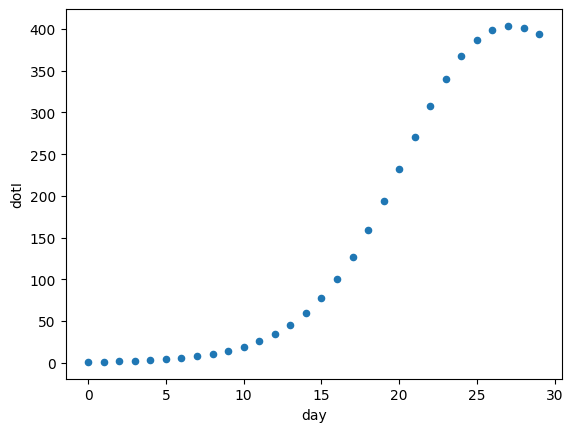

In [103]:
observed_data.plot.scatter("day", "dotI")

## Sobol Sensitivity Analysis

Next, let's use `calisim` to perform a sensitivity analysis of the end-of-simulation number of infected. To start with, we'll need to define our `ParameterSpecification` parameter specification:

In [104]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.3, 0.5],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="uniform",
			distribution_args=[0.05, 0.15],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

This contains information concerning the various parameter names, probability distributions, ranges, distribution parameters, and data types.

We next need to create a wrapper function around our forward model to ensure there's compatibility with the `calisim` API.

In [105]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    simulation_parameters = model.GROUND_TRUTH.copy()
    simulation_parameters["t"] = t

    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]

    simulated_data = sir_simulate(simulation_parameters).tail(1).dotI.item()
    return simulated_data

The last step is to create a `SensitivityAnalysisMethodModel` specification for the calibration procedure itself, which we then supply to a `SensitivityAnalysisMethod` calibrator. We'll use the `Sobol` method via the [SALib engine](https://salib.readthedocs.io/en/latest/), and calculate 95% confidence intervals for the indices.

In [106]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.dotI.values,
	method="sobol",
	n_samples=256,
	output_labels=["Number of Infected"],
    calibration_func_kwargs=dict(t=observed_data.day),
	method_kwargs=dict(calc_second_order=False, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=False,
		num_resamples=300,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

Finally, we'll run the calibration procedure. This is composed of 3 steps:

1. **Specify**: Define your calibration problem: Parameter distributions, observed data, objective/discrepancy function, and calibration settings (like algorithm, directions, iterations)
2. **Execute**: Run the actual calibration process (simulation + optimization/inference)
3. **Analyze**: Process, summarize, and optionally save plots/metrics of the calibration results

Or **SEA**.

/mnt/c/Users/james/projects/model-calibration-toolbox/.venv/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



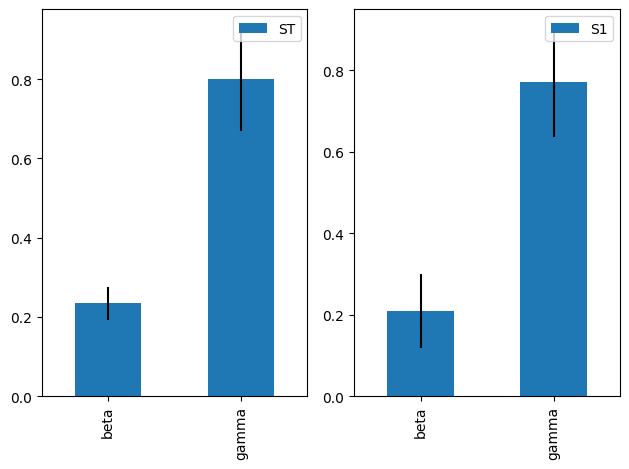

/mnt/c/Users/james/projects/model-calibration-toolbox/.venv/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



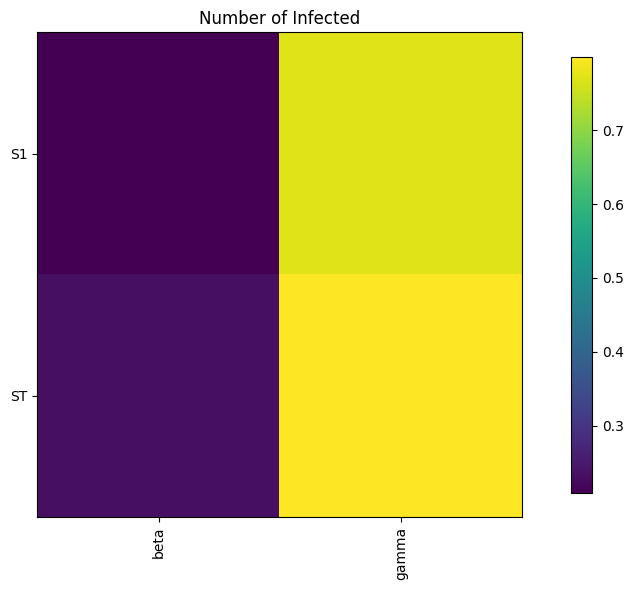

In [107]:
calibrator.specify().execute().analyze()

According to the indices above, the variation in the end-of-simulation number of infected is more greatly influenced by *γ* over *β*. Hence, we should generally prioritise the former over the latter for calibration. 

## Sobol Sensitivity Analysis via Polynomial Chaos

One advantage of `calisim` is the ability to compare different libraries, algorithms, and calibration methods. Let's construct Sobol sensitivity indices by fitting a polynomial chaos expansion surrogate model using the [OpenTurns engine](https://openturns.github.io/www/). 

We can reuse both the parameter specification and wrapper function defined above. But we will need to change the calibration specification.

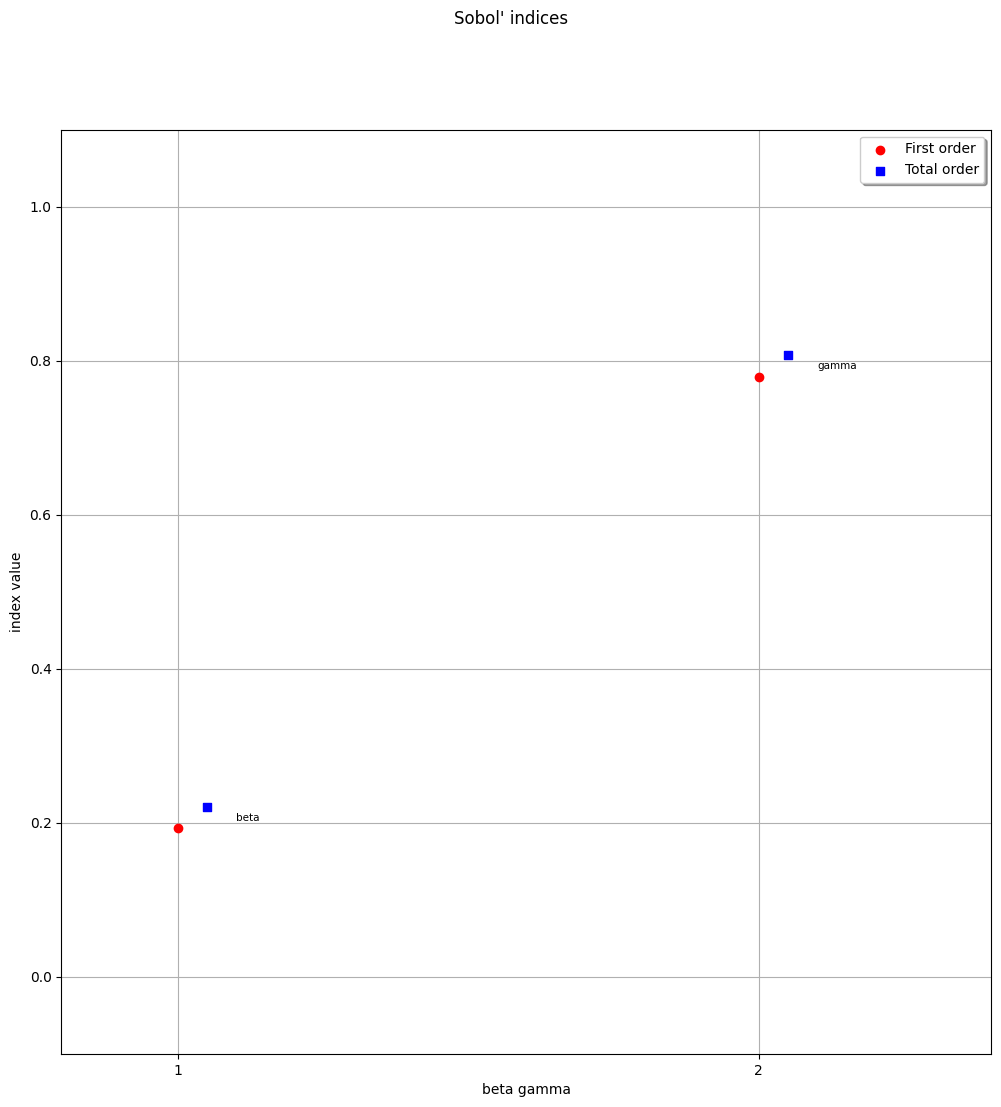

In [108]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="openturns_sensitivity_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_data,
	method="chaos_sobol",
	order=2,
	n_samples=256,
	output_labels=["Number of Infected"],
	calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="openturns"
)

calibrator.specify().execute().analyze()

Our surrogate model produces comparable sensitivity indices to the Sobol method.